In [1]:
import keras_cv
import keras
import matplotlib.pyplot as plt
from keras import ops
import numpy as np
import math
from PIL import Image

# Enable mixed precision
# (only do this if you have a recent NVIDIA GPU)
keras.mixed_precision.set_global_policy("mixed_float16")

# Instantiate the Stable Diffusion model
model = keras_cv.models.StableDiffusion(jit_compile=True)

2025-11-12 15:38:49.822050: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


/home/xy/Desktop/ml/GDL/tf_2.20/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
prompt_1 = "A watercolor painting of a Golden Retriever at the beach"
prompt_2 = "A still life DSLR photo of a bowl of fruit"
interpolation_steps = 5

encoding_1 = ops.squeeze(model.encode_text(prompt_1))
encoding_2 = ops.squeeze(model.encode_text(prompt_2))

interpolated_encodings = ops.linspace(encoding_1, encoding_2, interpolation_steps)

# Show the size of the latent manifold
print(f"Encoding shape: {encoding_1.shape}")

1356917/1356917 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


I0000 00:00:1762958351.352530   20508 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8858 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:08:00.0, compute capability: 7.5


492466864/492466864 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


2025-11-12 15:39:37.870884: I external/local_xla/xla/service/service.cc:163] XLA service 0x70b3500020a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-12 15:39:37.870896: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-11-12 15:39:37.946534: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-12 15:39:38.180368: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91500
I0000 00:00:1762958379.084014   20715 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Encoding shape: (77, 768)


In [3]:
seed = 12345
noise = keras.random.normal((512 // 8, 512 // 8, 4), seed=seed)

images = model.generate_image(
    interpolated_encodings,
    batch_size=interpolation_steps,
    diffusion_noise=noise,
)

3439090152/3439090152 ━━━━━━━━━━━━━━━━━━━━ 94s 0us/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 166s 561ms/step
198180272/198180272 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


2025-11-12 15:42:51.514366: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng31{k2=2,k6=2,k13=1,k14=0,k22=2} for conv (f16[5,256,256,512]{3,2,1,0}, u8[0]{0}) custom-call(f16[5,256,256,512]{3,2,1,0}, f16[512,3,3,512]{3,2,1,0}, f16[512]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]} is taking a while...
2025-11-12 15:42:51.725594: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The operation took 1.211296028s
Trying algorithm eng31{k2=2,k6=2,k13=1,k14=0,k22=2} for conv (f16[5,256,256,512]{3,2,1,0}, u8[0]{0}) custom-call(f16[5,256,256,512]{3,2,1,0}, f16[512,3,3,512]{3,2,1,0}, f16[512]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=

In [5]:
def export_as_gif(filename, images, frames_per_second=10, rubber_band=False):
    if rubber_band:
        images += images[2:-1][::-1]
    images[0].save(
        filename,
        save_all=True,
        append_images=images[1:],
        duration=1000 // frames_per_second,
        loop=0,
    )


export_as_gif(
    "doggo-and-fruit-5.gif",
    [Image.fromarray(img) for img in images],
    frames_per_second=2,
    rubber_band=True,
)

In [6]:
interpolation_steps = 150
batch_size = 3
batches = interpolation_steps // batch_size

interpolated_encodings = ops.linspace(encoding_1, encoding_2, interpolation_steps)
batched_encodings = ops.split(interpolated_encodings, batches)

images = []
for batch in range(batches):
    images += [
        Image.fromarray(img)
        for img in model.generate_image(
            batched_encodings[batch],
            batch_size=batch_size,
            num_steps=25,
            diffusion_noise=noise,
        )
    ]

export_as_gif("doggo-and-fruit-150.gif", images, rubber_band=True)

25/25 ━━━━━━━━━━━━━━━━━━━━ 33s 365ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 422ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 431ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 431ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 431ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 431ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 431ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 432ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 432ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 432ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 432ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 432ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 431ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 432ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 432ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 432ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 436ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 431ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 432ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 432ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 432ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 432ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 432ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 432

50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 337ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 423ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 431ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 432ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 432ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 433ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 433ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 432ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 433ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 433ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 433ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 433ms/step


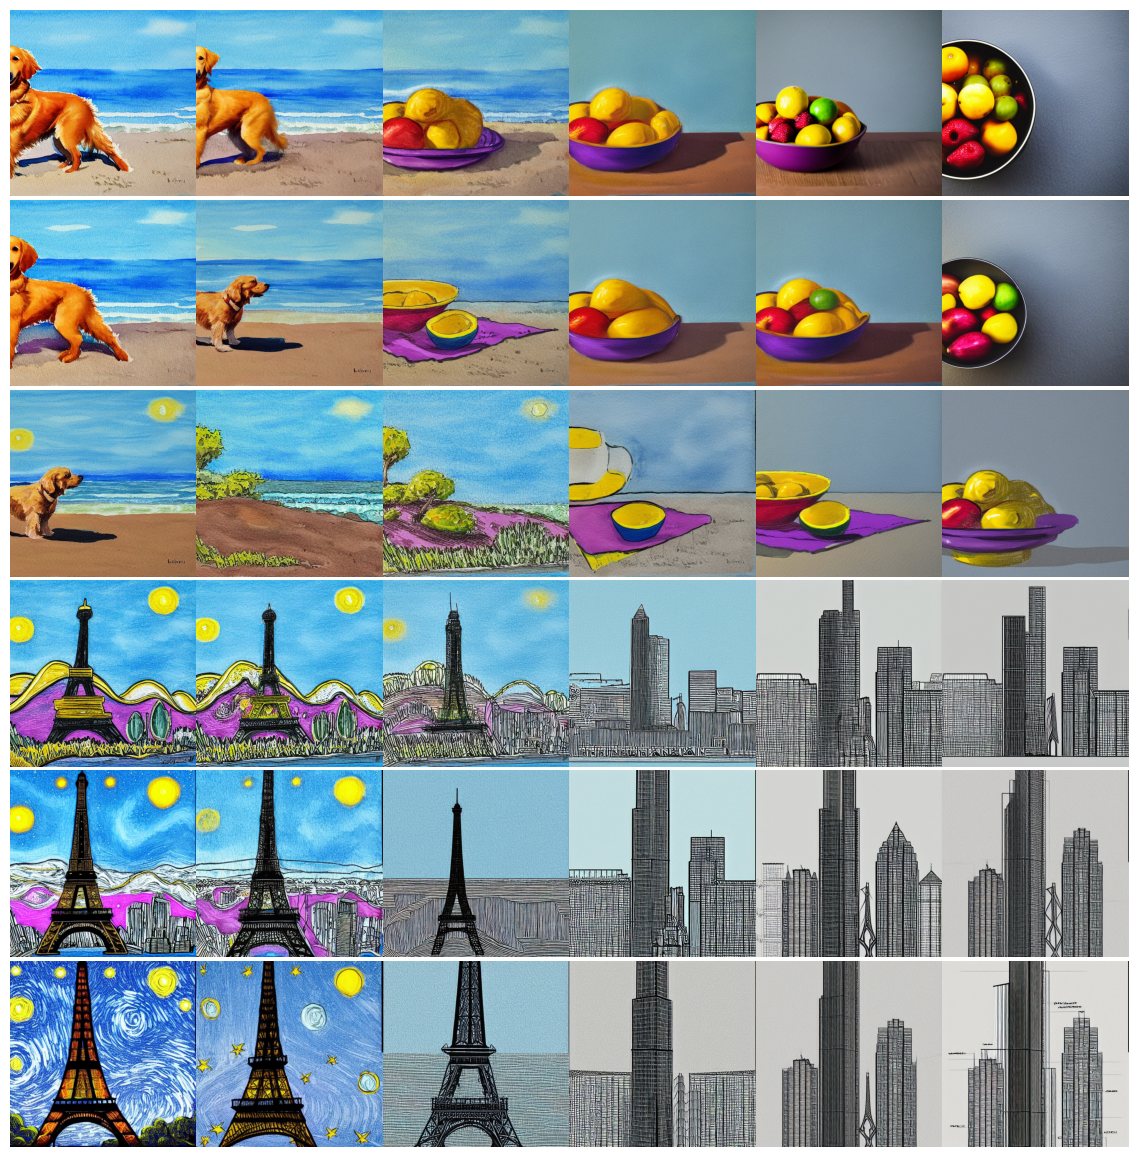

In [7]:
prompt_1 = "A watercolor painting of a Golden Retriever at the beach"
prompt_2 = "A still life DSLR photo of a bowl of fruit"
prompt_3 = "The eiffel tower in the style of starry night"
prompt_4 = "An architectural sketch of a skyscraper"

interpolation_steps = 6
batch_size = 3
batches = (interpolation_steps**2) // batch_size

encoding_1 = ops.squeeze(model.encode_text(prompt_1))
encoding_2 = ops.squeeze(model.encode_text(prompt_2))
encoding_3 = ops.squeeze(model.encode_text(prompt_3))
encoding_4 = ops.squeeze(model.encode_text(prompt_4))

interpolated_encodings = ops.linspace(
    ops.linspace(encoding_1, encoding_2, interpolation_steps),
    ops.linspace(encoding_3, encoding_4, interpolation_steps),
    interpolation_steps,
)
interpolated_encodings = ops.reshape(
    interpolated_encodings, (interpolation_steps**2, 77, 768)
)
batched_encodings = ops.split(interpolated_encodings, batches)

images = []
for batch in range(batches):
    images.append(
        model.generate_image(
            batched_encodings[batch],
            batch_size=batch_size,
            diffusion_noise=noise,
        )
    )


def plot_grid(images, path, grid_size, scale=2):
    fig, axs = plt.subplots(
        grid_size, grid_size, figsize=(grid_size * scale, grid_size * scale)
    )
    fig.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis("off")
    for ax in axs.flat:
        ax.axis("off")

    images = images.astype(int)
    for i in range(min(grid_size * grid_size, len(images))):
        ax = axs.flat[i]
        ax.imshow(images[i].astype("uint8"))
        ax.axis("off")

    for i in range(len(images), grid_size * grid_size):
        axs.flat[i].axis("off")
        axs.flat[i].remove()

    plt.savefig(
        fname=path,
        pad_inches=0,
        bbox_inches="tight",
        transparent=False,
        dpi=60,
    )


images = np.concatenate(images)
plot_grid(images, "4-way-interpolation.jpg", interpolation_steps)

50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 419ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 430ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 430ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 431ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 432ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 431ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 431ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 431ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 431ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 430ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 431ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 458ms/step


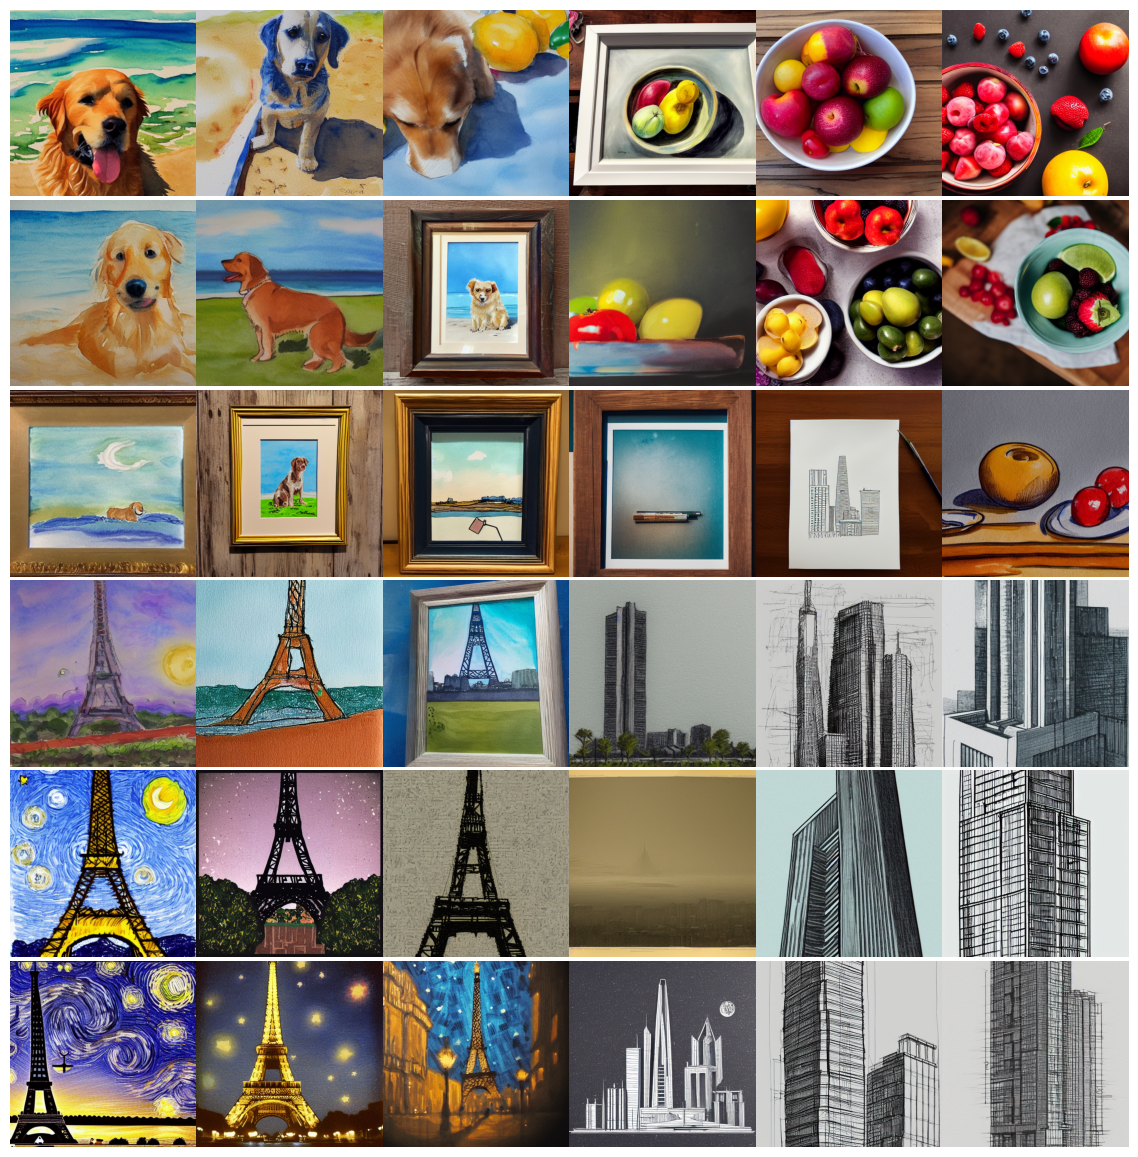

In [8]:
images = []
for batch in range(batches):
    images.append(model.generate_image(batched_encodings[batch], batch_size=batch_size))

images = np.concatenate(images)
plot_grid(images, "4-way-interpolation-varying-noise.jpg", interpolation_steps)

In [9]:
walk_steps = 150
batch_size = 3
batches = walk_steps // batch_size
step_size = 0.005

encoding = ops.squeeze(
    model.encode_text("The Eiffel Tower in the style of starry night")
)
# Note that (77, 768) is the shape of the text encoding.
delta = ops.ones_like(encoding) * step_size

walked_encodings = []
for step_index in range(walk_steps):
    walked_encodings.append(encoding)
    encoding += delta
walked_encodings = ops.stack(walked_encodings)
batched_encodings = ops.split(walked_encodings, batches)

images = []
for batch in range(batches):
    images += [
        Image.fromarray(img)
        for img in model.generate_image(
            batched_encodings[batch],
            batch_size=batch_size,
            num_steps=25,
            diffusion_noise=noise,
        )
    ]

export_as_gif("eiffel-tower-starry-night.gif", images, rubber_band=True)

25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 434ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 431ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 429ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 432ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 426ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 432ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 431ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 423ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 422ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 421ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 431ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 433ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 419ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 417ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 422ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 418ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 415ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 451ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 410ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 404ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 410ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 403ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 403ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 402

In [10]:
prompt = "An oil paintings of cows in a field next to a windmill in Holland"
encoding = ops.squeeze(model.encode_text(prompt))
walk_steps = 150
batch_size = 3
batches = walk_steps // batch_size

walk_noise_x = keras.random.normal(noise.shape, dtype="float64")
walk_noise_y = keras.random.normal(noise.shape, dtype="float64")

walk_scale_x = ops.cos(ops.linspace(0, 2, walk_steps) * math.pi)
walk_scale_y = ops.sin(ops.linspace(0, 2, walk_steps) * math.pi)
noise_x = ops.tensordot(walk_scale_x, walk_noise_x, axes=0)
noise_y = ops.tensordot(walk_scale_y, walk_noise_y, axes=0)
noise = ops.add(noise_x, noise_y)
batched_noise = ops.split(noise, batches)

images = []
for batch in range(batches):
    images += [
        Image.fromarray(img)
        for img in model.generate_image(
            encoding,
            batch_size=batch_size,
            num_steps=25,
            diffusion_noise=batched_noise[batch],
        )
    ]

export_as_gif("cows.gif", images)

25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 269ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 317ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 369ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 396ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 386ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 386ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 392ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 388ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 392ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 389ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 396ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 389ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 389ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 393ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 389ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 394ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 389ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 394ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 389ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 388ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 394ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 387ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 387ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 388ms